# Introduction
1. <a href='#Key-points'>Key points</a>
2. <a href='#Data-Preparation'>Data Preparation</a>
2. <a href='#Matching-Implementation'>Matching implementation</a>
3. <a href='#Matching-Review'>Matching Review</a>
4. <a href='#Average-Treatement-effect'>Average Treatement Effect</a>
1. <a href='#References'>References</a>

# Key points
- Conditional Indipendence Assumption: There are no unobserved differences correlated to potential outcomes once we have controlled for certain observable characteristics
- Participation can be considered random among observations with the same characteristics
- Identification condition: observations with similar characteristics X present in both treatment and control groups. This requires 0 < P(T=1|X) < 1
- Selection on treatment (or not) should be solely based on observable characteristics (i.e. X). Assuming there is no selection bias from unobserved characteristics. It is not possible to prove the validity of this unconfoundedness assumption.
- There is a cost in not doing RCT (randomised controlled testing)
- Curse of dimensionality -> propensity score matching
- Prop. score: propability of participating in the treatment based on observable characteristics (i.e. X)

# Data Preparation

In [92]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [93]:
from functions import *
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [94]:
df = pd.read_csv('train.csv')
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

First view of usual Titanic dataset:

In [95]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Create an artificial treatment effect. It is based on the condition that a passenger has a cabin (1) or not (0).

In [96]:
df['treatment'] = df.Cabin.apply(hasCabin)

There is high correlation between treatment (i.e. hasCabin) and Class.
This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
In a different context this could be a landing page on site that only specific visitors see.

In [97]:
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,26,158,345
1,158,15,10


Keeping only specific variables
We should account for all variables that affect the treatment variable (i.e. hasCabin)

In [98]:
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]

In [99]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [100]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [101]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [102]:
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)

In [103]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))

Accuracy: 0.9284

Confusion matrix:
[[503  26]
 [ 25 158]]

F1 score is: 0.8610


Convert propability to logit (based on the suggestion at https://youtu.be/gaUgW7NWai8?t=981)

In [104]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

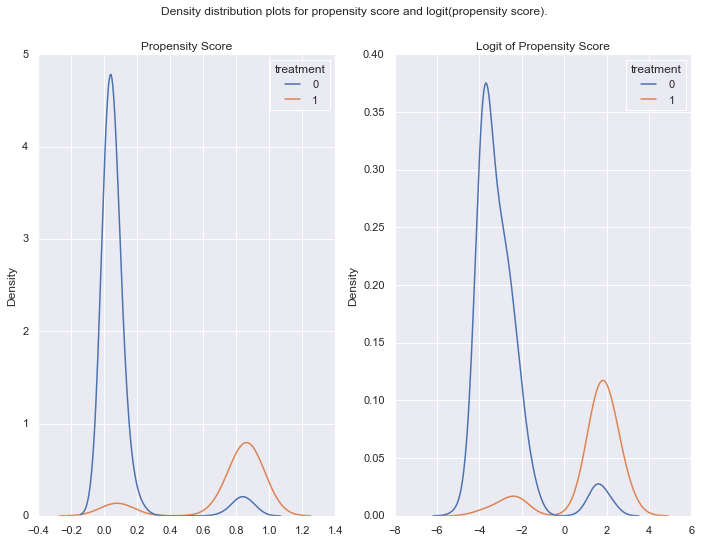

In [105]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].set_title('Logit of Propensity Score')
plt.show()

There is good overlap only between -3 and -1 for logit propensity score. That area contains a lot more untreated samples versus the treated ones. This will give us a good pool of samples to perform the matching and obtain a more balanced view of the covariates.

In [106]:
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [107]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [130]:
X_encoded.loc[0]

Age                       22.000000
SibSp                      1.000000
Parch                      0.000000
Fare                       7.250000
sex_female                 0.000000
sex_male                   1.000000
embarked_C                 0.000000
embarked_Q                 0.000000
embarked_S                 1.000000
class_1                    0.000000
class_2                    0.000000
class_3                    1.000000
propensity_score           0.021156
propensity_score_logit    -3.834463
outcome                    0.000000
treatment                  0.000000
Name: 0, dtype: float64

Within the common support area, there are 25 treated samples. There are 152 untreated samples that we can use as a pool for the matching.

In [109]:
df_data.treatment.value_counts()

0    529
1    183
Name: treatment, dtype: int64

## Matching Implementation
Use Nearerst Neighbors to perform 1-to-1 matching. 
- Caliper: 25% of standart deviation of logit(propensity score)

In [110]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded.loc[common_support].reset_index().rename(columns = {'index':'old_index'})

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(n_neighbors=10, radius=0.08890268148266278)

For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.

In [111]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [112]:
print('For item 0, the closest distances are (first item is self):')
for ds in distances[0,:]:
    print(ds)

For item 0, the closest distances are (first item is self):
0.0
2.133172338147915e-05
0.0011057978449575678
0.004490389965868147
0.0065401887632070554
0.0067485882833278055
0.0071181650542477826
0.00854491653040057
0.009792594755860584
0.010410810850028263


In [113]:
print('For item 0, the closest indexes are (first item is self):')
for ds in indexes[0,:]:
    print(ds)

For item 0, the closest indexes are (first item is self):
0
607
539
301
590
641
611
36
134
449


In [129]:
# df_data[df_data.propensity_score_logit > 2]

For each data points with treatment equal 1 (T=1), obtain the nearest neighbor that has treatment 0 (T=0).

In [115]:
def perfom_matching(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (prop_score_logit < -1) and (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
        elif (prop_score_logit > -1) and (current_index != idx) and (row.treatment == 0) and (df_data.loc[idx].treatment == 1):
            return int(idx)
        
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching, axis = 1, args = (indexes, df_data))

In [116]:
treated_with_match = ~df_data.matched_element.isna()
untreated_with_match = df_data.reset_index()['index'].isin(df_data.matched_element)

In [117]:
all_matched_elements = pd.DataFrame(data = {'a' : treated_with_match, 'b' :untreated_with_match}).any(axis = 1)

In [118]:
matched_data = df_data.loc[all_matched_elements]

In [119]:
matched_data[['propensity_score','propensity_score_logit','outcome','treatment','matched_element']].head(5)

,propensity_score,propensity_score_logit,outcome,treatment,matched_element
3,0.895107,2.144005,1,1,NaN
5,0.805110,1.418544,0,1,NaN
9,0.063216,-2.695902,1,1,686.0
18,0.059719,-2.756534,1,1,636.0
22,0.102161,-2.173435,1,0,NaN


Items that have treatment = 0, do not hold the matched-element information. This is held at their counterparts elements (i.e. when T=1)

In [120]:
matched_data.treatment.value_counts()

0    51
1    50
Name: treatment, dtype: int64

In total 25 treated elements (i.e. hasCabin = True) have been matched with 24 untreated elements.

# Matching Review

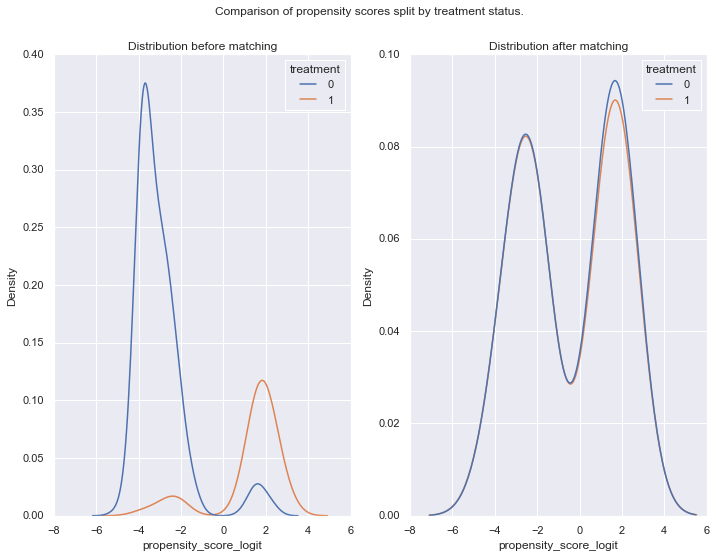

In [121]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Comparison of propensity scores split by treatment status.')
sns.kdeplot(data = df_data, x = 'propensity_score_logit', hue = 'treatment', ax = ax[0]).set(title='Distribution before matching')
sns.kdeplot(data = matched_data, x = 'propensity_score_logit', hue = 'treatment',  ax = ax[1]).set(title='Distribution after matching')
plt.show()

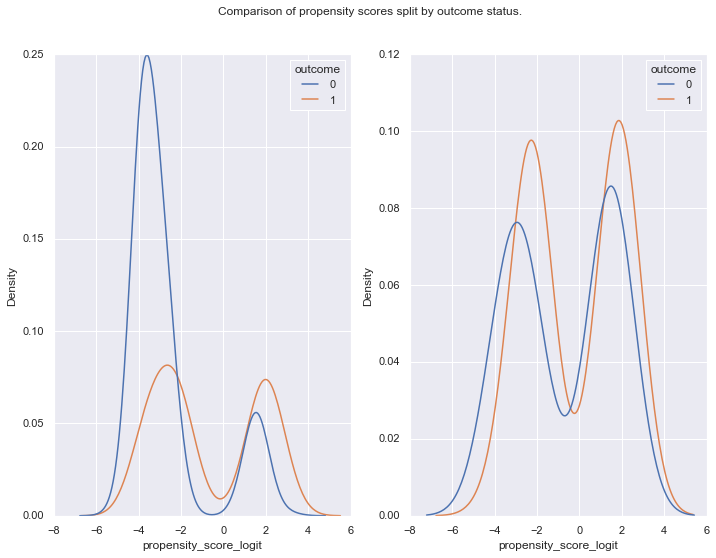

In [122]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Comparison of propensity scores split by outcome status.')
sns.kdeplot(data = df_data, x = 'propensity_score_logit', hue = 'outcome', ax = ax[0])
sns.kdeplot(data = matched_data, x = 'propensity_score_logit', hue = 'outcome', ax = ax[1])

In [123]:
data = []
# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S','class_1','class_2','class_3']
cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(matched_data,cl)])

In [124]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

[Text(0.5, 1.0, 'Mean differences between treatment groups before and after matching.')]

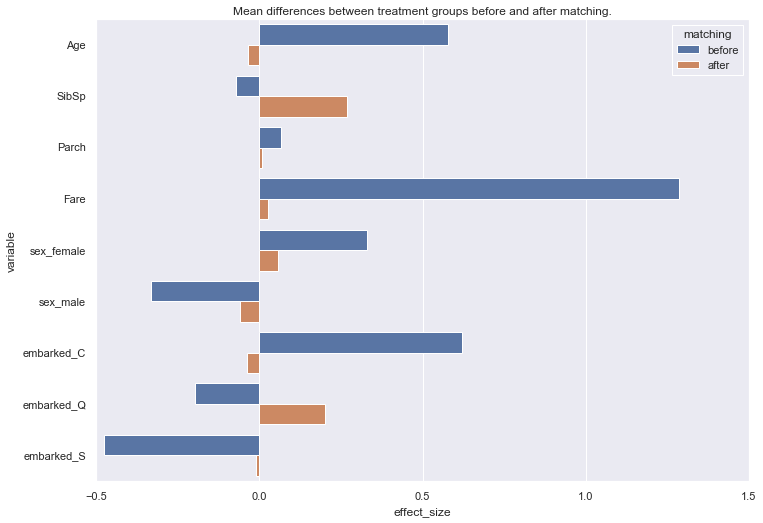

In [125]:
sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h').set(title='Mean differences between treatment groups before and after matching.')

In [126]:
cols.append('treatment')

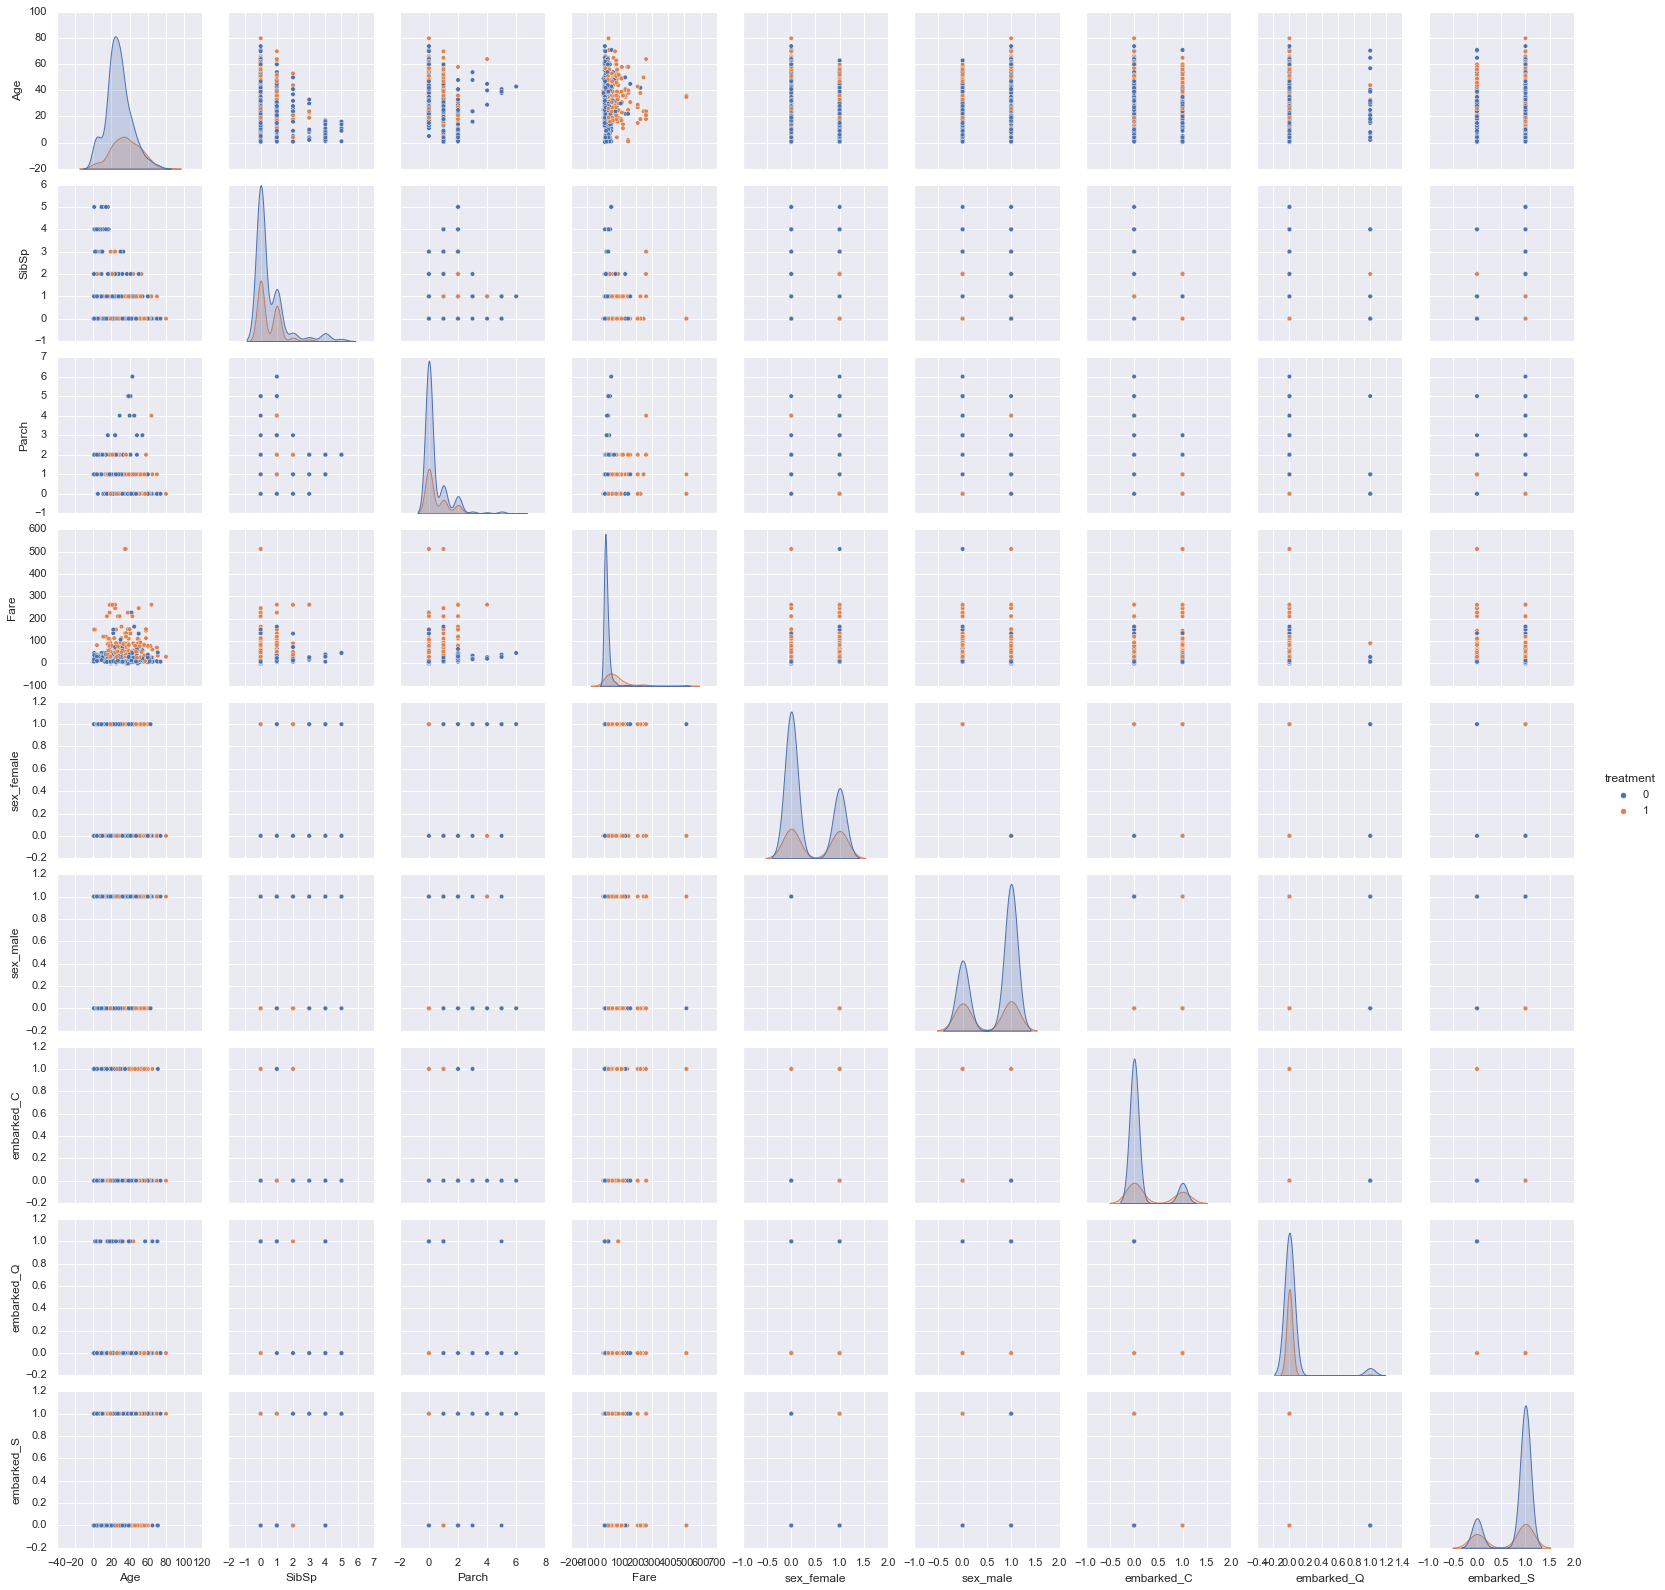

In [127]:
sns.pairplot(data = df_data[cols], hue = 'treatment')

/Users/konos/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


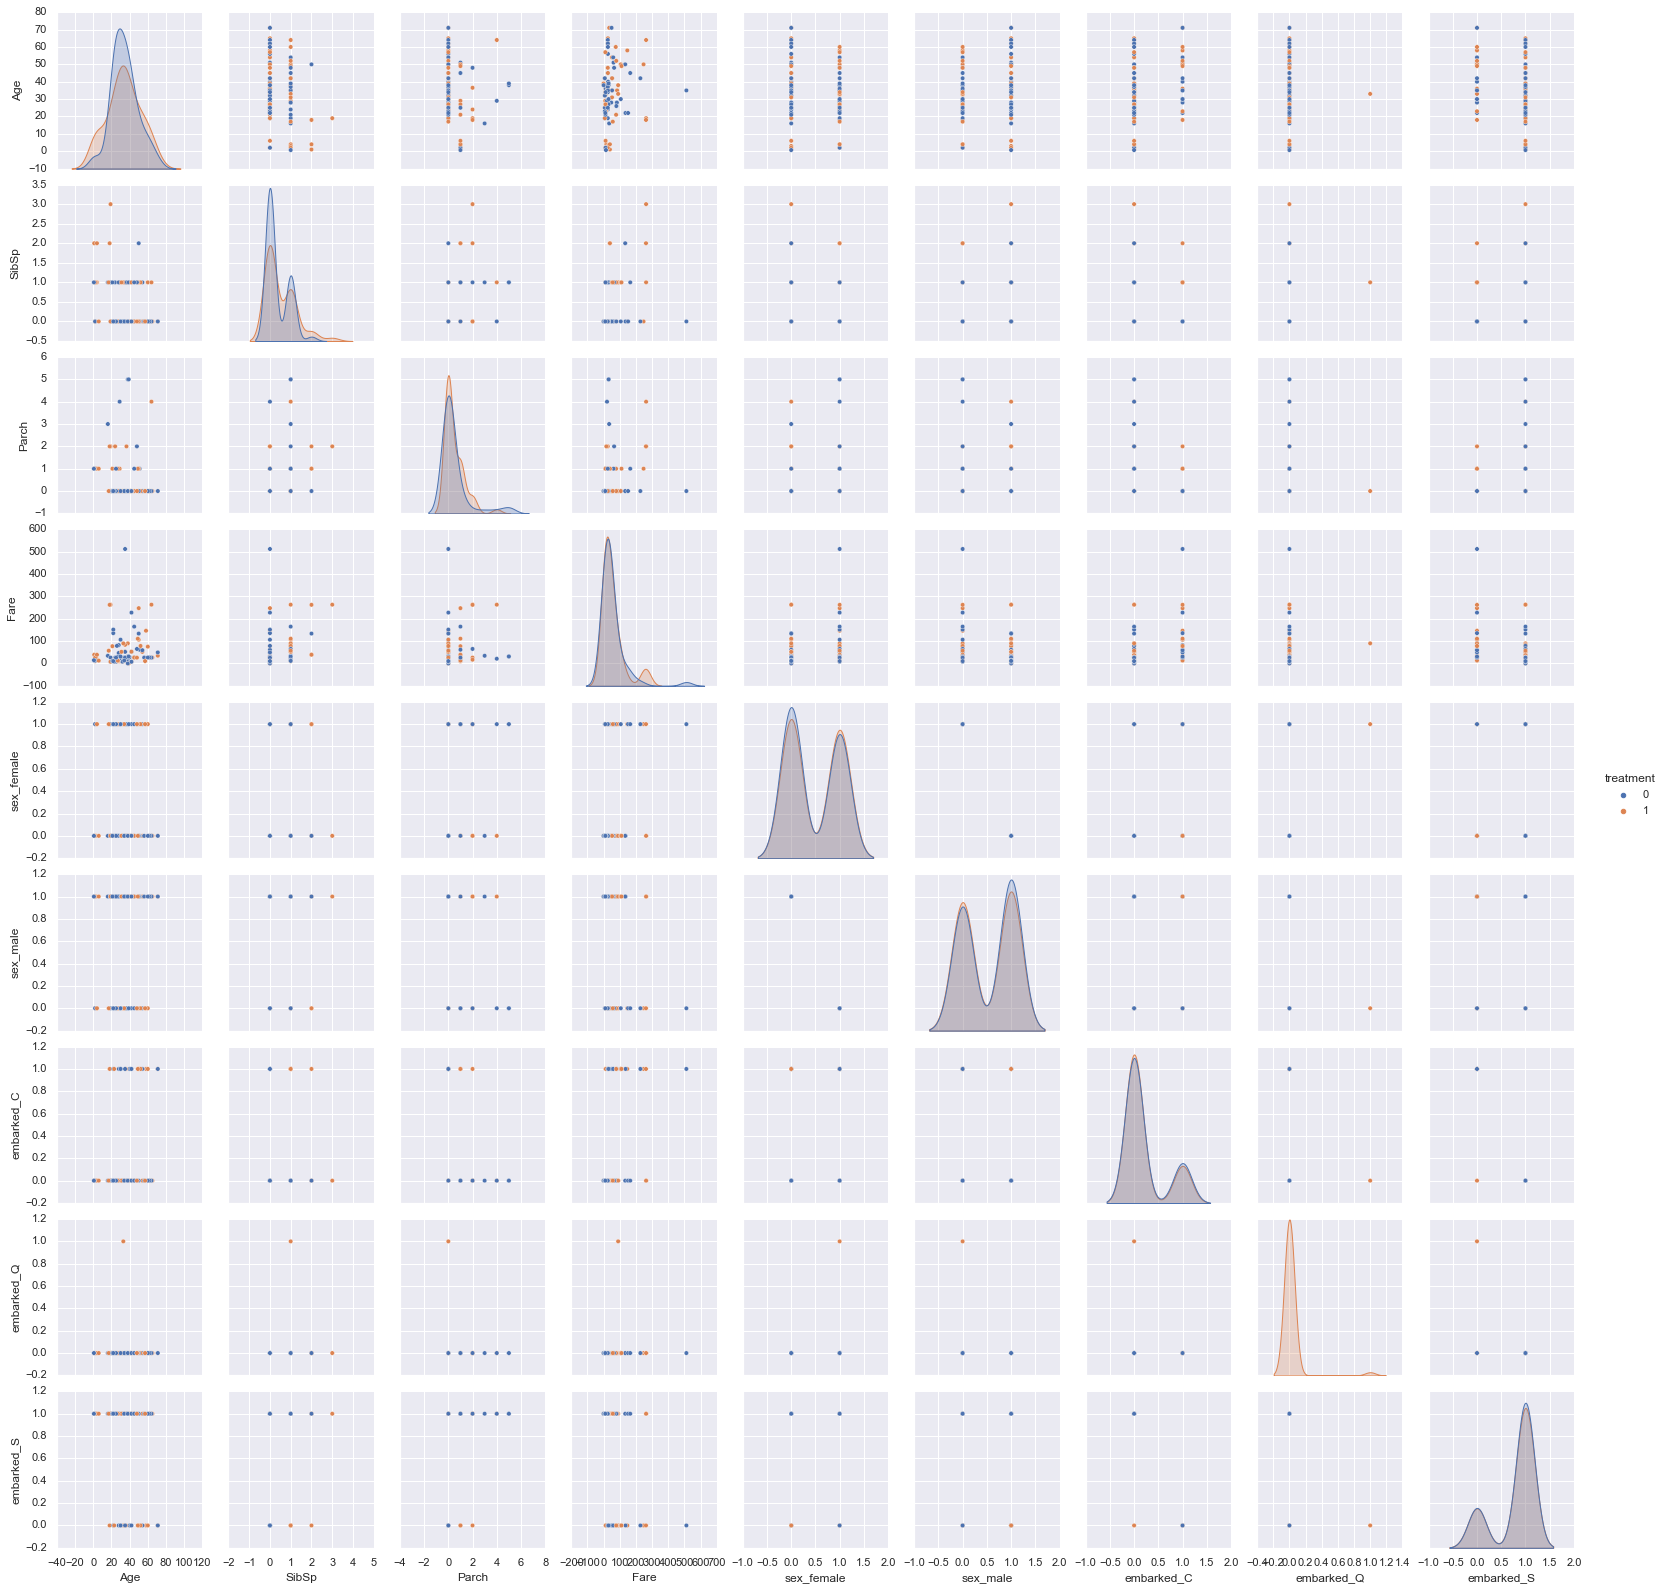

In [128]:
sns.pairplot(data = matched_data[cols], hue = 'treatment')

# Average Treatement effect

# References
- Logit function definition: https://en.wikipedia.org/wiki/Logit
- Matching Methods: https://www.youtube.com/watch?v=CEikQRj5n_A
- Propensity Score Matching: https://www.youtube.com/watch?v=8KE0qj5Ef0c
- Propensity Score Matching - HelloFresh: https://www.youtube.com/watch?v=gaUgW7NWai8
- Introduction to Propensity Score Matching: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
- https://florianwilhelm.info/2017/04/causal_inference_propensity_score/
- Cohen's d: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d